# Network Analysis

In [60]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from matplotlib import pyplot as plt
from collections import Counter
from itertools import combinations

In [61]:
data_path = "./../../data/inference/"
output_path = "graphs/"

In [62]:
decades = list(range(1840, 2000, 10))
mentions_fr = pd.read_pickle(data_path + "mentions_fr.pkl")
mentions_de = pd.read_pickle(data_path + 'mentions_de.pkl')
mentions_all = pd.concat([mentions_fr, mentions_de])

In [63]:
mentions_all.head()

,entity,surface,qid,lSentenceOffset,rSentenceOffset,sentence_idx:,lArticleOffset,rArticleOffset,id,article,newspaper,date,year,decade,agency,language,country
0,org.ent.pressagency.Havas,Havas,Q2826560,30,35,1,84,89,LLE-1939-11-27-a-i0076:1:30:35:84:89:newsag:be...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,Havas,fr,CH
1,org.ent.pressagency.UP-UPI,United Press,Q493845,2,14,7,595,607,LLE-1939-11-27-a-i0076:7:2:14:595:607:newsag:b...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
2,org.ent.pressagency.UP-UPI,United Press,Q493845,0,12,10,1364,1376,LLE-1939-11-27-a-i0076:10:0:12:1364:1376:newsa...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
3,org.ent.pressagency.UP-UPI,United Press,Q493845,2,14,16,2181,2193,LLE-1939-11-27-a-i0076:16:2:14:2181:2193:newsa...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
4,org.ent.pressagency.UP-UPI,Press,Q493845,48,53,18,2531,2536,LLE-1939-11-27-a-i0076:18:48:53:2531:2536:news...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH


### Cleaning step: Official Start and end date of news agencies

In [64]:
ag_list = pd.read_csv(data_path + "NA_list.csv", delimiter=";", usecols=['Abbr.', 'News Agency', 'Country', 'Creation', 'End']).set_index('Abbr.')
ag_list = ag_list.rename(columns={'Creation': 'start_year', 'End': 'end_year'})
ag_list.head()

,News Agency,Country,start_year,end_year
Abbr.,,,,
AFP,Agence France-Presse,France,1944.0,NaN
ANP,Algemeen Nederlands Persbureau,Netherlands,1934.0,NaN
ANSA,Agenzia Nationale Stampa Associata,Italy,1945.0,NaN
AP,Associated Press,USA,1848.0,NaN
APA,Austria Press Agentur,Austria,1946.0,NaN


In [65]:
#get information on news agencies
df_newsagencies = mentions_all[['agency', 'year', 'language']].groupby('agency').agg({'language': set})

df_newsagencies['language'] = df_newsagencies['language'].apply(lambda x: ", ".join(x))
df_newsagencies = df_newsagencies.join(ag_list, how='left')
#use generic start and end dates if none exist
df_newsagencies['start_year'] = df_newsagencies['start_year'].fillna(1840).astype(int)
df_newsagencies['end_year'] = df_newsagencies['end_year'].fillna(2020).astype(int)
#put end_year for Havas to 1944, as it was often cited as Havas-OFI during war
df_newsagencies.loc['Havas', 'end_year'] = 1944
#give rough timespan for Europapress based on agency count below
df_newsagencies.loc['Europapress', 'start_year'] = 1918
df_newsagencies.loc['Europapress', 'end_year'] = 1941

df_newsagencies = df_newsagencies.fillna('unk')
df_newsagencies

,language,News Agency,Country,start_year,end_year
AFP,"fr, de",Agence France-Presse,France,1944,2020
AP,"fr, de",Associated Press,USA,1848,2020
ATS-SDA,"fr, de",Agence Telegraphique Suisse/Schweizerische Dep...,Switzerland,1894,2020
DDP-DAPD,de,Deutscher Depeschendienst/Deutscher Auslands-D...,Germany,1971,2013
DNB,"fr, de",Deutsches Nachrichtenbüro GmbH,Germany,1933,1945
DPA,"fr, de",Deutsche Presse Agentur,Germany (GFR),1949,2020
Europapress,de,Europapress,Germany,1918,1941
Extel,"fr, de",Exchange Telegraph Co. Ltd.,United Kingdom,1872,1993
Havas,"fr, de",Havas,France,1835,1944
Kipa,de,Katholische internationale Presseagentur / Age...,Switzerland,1917,2015


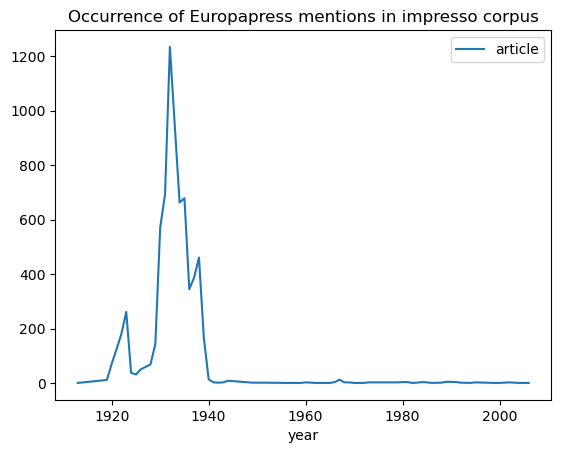

In [66]:
mentions_all.loc[mentions_all['agency'] == 'Europapress', ['article', 'year']].groupby('year').count().plot(title='Occurrence of Europapress mentions in impresso corpus')
plt.show()

In [67]:
#delete mentions which were not within the existence span of an agency
len_before = len(mentions_all)

mentions_all = mentions_all.merge(df_newsagencies.reset_index()[['index', 'start_year', 'end_year']], left_on='agency', right_on='index', how='left')
mentions_all = mentions_all[(mentions_all['start_year'] <= mentions_all['year']) &
                            (mentions_all['year'] <= mentions_all['end_year'])]
mentions_all = mentions_all.drop(columns=['index', 'start_year', 'end_year'])

print(f"#deleted mentions: {len_before - len(mentions_all)} ({round((len_before - len(mentions_all))/len_before * 100)}%)")
mentions_all.head()

#deleted mentions: 60381 (1%)


,entity,surface,qid,lSentenceOffset,rSentenceOffset,sentence_idx:,lArticleOffset,rArticleOffset,id,article,newspaper,date,year,decade,agency,language,country
0,org.ent.pressagency.Havas,Havas,Q2826560,30,35,1,84,89,LLE-1939-11-27-a-i0076:1:30:35:84:89:newsag:be...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,Havas,fr,CH
1,org.ent.pressagency.UP-UPI,United Press,Q493845,2,14,7,595,607,LLE-1939-11-27-a-i0076:7:2:14:595:607:newsag:b...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
2,org.ent.pressagency.UP-UPI,United Press,Q493845,0,12,10,1364,1376,LLE-1939-11-27-a-i0076:10:0:12:1364:1376:newsa...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
3,org.ent.pressagency.UP-UPI,United Press,Q493845,2,14,16,2181,2193,LLE-1939-11-27-a-i0076:16:2:14:2181:2193:newsa...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
4,org.ent.pressagency.UP-UPI,Press,Q493845,48,53,18,2531,2536,LLE-1939-11-27-a-i0076:18:48:53:2531:2536:news...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH


### Import newspaper list

In [68]:
newspapers = mentions_all[['newspaper', 'language', 'country']].groupby('newspaper').first()
newspapers.head()

,language,country
newspaper,,
BLB,de,CH
BNN,de,CH
CDV,fr,CH
CON,fr,CH
DFS,de,CH


In [69]:
np_info = pd.read_csv(data_path + "impresso_newspapers_abbrev_20230719.csv").set_index('id')
np_info.head()

,title,start_year,end_year
id,,,
actionfem,L'Action féminine,1927.0,1940.0
arbeitgeber,Schweizer Arbeitgeber,1906.0,1994.0
armeteufel,Arme Teufel,1903.0,1929.0
avenirgdl,L'avenir,1868.0,1871.0
BDC,Bulletin des séances de la Constituante,1839.0,1839.0


In [180]:
np_df = newspapers.join(np_info, how="left")
#check if data is missing
print(np_df.isna().sum())
np_df[np_df['country'] == 'LU']

language      0
country       0
title         0
start_year    0
end_year      0
dtype: int64


,language,country,title,start_year,end_year
newspaper,,,,,
actionfem,de,LU,L'Action féminine,1927.0,1940.0
armeteufel,de,LU,Arme Teufel,1903.0,1929.0
avenirgdl,fr,LU,L'avenir,1868.0,1871.0
buergerbeamten,de,LU,Bürger- und Beamten-Zeitung,1898.0,1916.0
courriergdl,fr,LU,Courrier du Grand-Duché de Luxembourg,1844.0,1868.0
deletz1893,de,LU,De Letzeburger,1893.0,1909.0
demitock,de,LU,De Mitock e Wocheblad fir Jux an Zodi,1937.0,1940.0
diekwochen,de,LU,Diekircher Wochenblatt,1841.0,1848.0
dunioun,fr,LU,D'Unio'n,1944.0,1948.0


## Create Multigraph

In [71]:
def make_multigraph(df, edge_cols, node_dfs=[], bipartite=True, node0='newspaper', node1='agency', print_attrs=True):
    """
    Creates (undirected) Multigraph with newspapers and/or agencies as nodes and the references between them as edges.

    Parameters
        :df: pd.Dataframe with edge data
        :edge_cols: list of columns of df which contain edge attributes
        :node_dfs: list of pd.Dataframes, each Dataframes containing data for node attributes
        :bipartite: if set to True, nodes from column node0 get attribute '0' and node1 get '1'
        :node0: column containing first node of an edge
        :node1: column containing second node of an edge
        :print_attrs: if set to True, beginnings of the edge- and node-list are printed to the screen

    Returns: nx.Multigraph G
    """

    #make edge list
    edge_attrs = df[edge_cols].to_dict(orient='records')
    edge_list = list(zip(df[node0], df[node1], edge_attrs))

    #create graph
    G = nx.MultiGraph()
    keys = G.add_edges_from(edge_list)

    #add node attributes
    for node_df in node_dfs:
        node_attrs = node_df.to_dict(orient='records')
        node_dict = dict(zip(node_df.index,  node_attrs))
        nx.set_node_attributes(G, node_dict)

    if bipartite:
        #set newspaper node attr to 0, agency node attr to 1
        N0 = mentions_all[node0].unique()
        N1 = mentions_all[node1].unique()

        bipartite_attrs = dict(  list(zip( N0, [{"bipartite": 0}] * len(N0) )) +
                        list(zip( N1, [{"bipartite": 1}] * len(N1) ))
                        )
        nx.set_node_attributes(G, bipartite_attrs)

    if print_attrs:
        print(f"Edge list: {edge_list[:5]} ...")
        print(f"Node list: {list(G.nodes.data())[:5]} ...")

    
    return G

In [72]:
G_all = make_multigraph(mentions_all, edge_cols=['date', 'year', 'decade', 'language'], node_dfs=[np_df, df_newsagencies], bipartite=True)

Edge list: [('LLE', 'Havas', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'})] ...
Node list: [('LLE', {'language': 'fr', 'country': 'CH', 'title': 'La Liberté', 'start_year': 1871.0, 'end_year': 2018.0, 'bipartite': 0}), ('Havas', {'language': 'fr, de', 'News Agency': 'Havas', 'Country': 'France', 'start_year': 1835, 'end_year': 1944, 'bipartite': 1}), ('UP-UPI', {'language': 'fr, de', 'News Agency': 'United Press International', 'Country': 'USA', 'start_year': 1907, 'end_year': 1990, 'bipartite': 1}), ('Reuters', {'language': 'fr, de', 'News Agency': 'Reuters', 'Country': 'United Kingdom', 'start_year': 

## Make Multigraph with Edges grouped by Year

In [73]:
mentions_yearly = mentions_all[['newspaper', 'agency', 'year', 'decade', 'language']].groupby(['newspaper', 'agency', 'year']).agg({
    'language': 'count',
    'decade': 'first'
}).reset_index().rename(columns={'language': 'weight'})
mentions_yearly.head()

,newspaper,agency,year,weight,decade
0,BLB,Havas,1846,1,1840
1,BLB,unk,1847,1,1840
2,BNN,Havas,1886,2,1880
3,BNN,Havas,1887,16,1880
4,BNN,Havas,1888,26,1880


### Threshold

In [74]:
def get_percentage(df, col, value, decimals=0):
    df_selected = df[df[col] == value]
    return round(len(df_selected)/len(df)*100, decimals)

for value in range(1,13):
    print(f"%nodes with weight = {value}: {get_percentage(mentions_yearly, 'weight', value)}%")

%nodes with weight = 1: 19.0%
%nodes with weight = 2: 10.0%
%nodes with weight = 3: 6.0%
%nodes with weight = 4: 4.0%
%nodes with weight = 5: 3.0%
%nodes with weight = 6: 3.0%
%nodes with weight = 7: 2.0%
%nodes with weight = 8: 2.0%
%nodes with weight = 9: 2.0%
%nodes with weight = 10: 2.0%
%nodes with weight = 11: 1.0%
%nodes with weight = 12: 1.0%


In [75]:
#threshold >= 6: at least once every two months
mentions_yearly_min6 = mentions_yearly[mentions_yearly['weight'] >= 6]
#threshold >= 24: at least twice a month
mentions_yearly_min24 = mentions_yearly[mentions_yearly['weight'] >= 24]

### Make Graphs

In [76]:
print("Graph with all edges")
G_yearly = make_multigraph(mentions_yearly, edge_cols=['year', 'decade', 'weight'], node_dfs=[np_df, df_newsagencies], bipartite=True)
print("\nGraph with edges with weight >= 6")
G_yearly_min6 = make_multigraph(mentions_yearly_min6, edge_cols=['year', 'decade', 'weight'], node_dfs=[np_df, df_newsagencies], bipartite=True)
print("\nGraph with edges with weight >= 24")
G_yearly_min24 = make_multigraph(mentions_yearly_min24, edge_cols=['year', 'decade', 'weight'], node_dfs=[np_df, df_newsagencies], bipartite=True)

Graph with all edges


Edge list: [('BLB', 'Havas', {'year': 1846, 'decade': 1840, 'weight': 1}), ('BLB', 'unk', {'year': 1847, 'decade': 1840, 'weight': 1}), ('BNN', 'Havas', {'year': 1886, 'decade': 1880, 'weight': 2}), ('BNN', 'Havas', {'year': 1887, 'decade': 1880, 'weight': 16}), ('BNN', 'Havas', {'year': 1888, 'decade': 1880, 'weight': 26})] ...
Node list: [('BLB', {'language': 'de', 'country': 'CH', 'title': 'Bündner Landbote', 'start_year': 1846.0, 'end_year': 1847.0, 'bipartite': 0}), ('Havas', {'language': 'fr, de', 'News Agency': 'Havas', 'Country': 'France', 'start_year': 1835, 'end_year': 1944, 'bipartite': 1}), ('unk', {'language': 'fr, de', 'News Agency': 'unk', 'Country': 'unk', 'start_year': 1840, 'end_year': 2020, 'bipartite': 1}), ('BNN', {'language': 'de', 'country': 'CH', 'title': 'Bündner Nachrichten', 'start_year': 1885.0, 'end_year': 1892.0, 'bipartite': 0}), ('Reuters', {'language': 'fr, de', 'News Agency': 'Reuters', 'Country': 'United Kingdom', 'start_year': 1851, 'end_year': 2020,

### Normalize Edgeweights 
by number of articles in corpus

In [173]:
#import frequencies of articles in impresso per year
all_impresso_art_page = pd.read_csv(data_path + "counts_impresso_yearly_page-art.csv", delimiter=";", usecols=['Year', 'Number ar + page']).rename(
    columns={'Year': 'year', 'Number ar + page':'count'})
all_impresso_art_page = all_impresso_art_page.set_index('year')
all_impresso_art_page.tail()

,count
year,
2015,68400
2016,72246
2017,64434
2018,1828
1969,293199


In [176]:
G_yearly_min24_normalized = G_yearly_min24.copy()
for edge in G_yearly_min24_normalized.edges.data():
    year = edge[2]['year']
    edge[2]['weight'] = round(edge[2]['weight'] / all_impresso_art_page.loc[year, 'count'] * 100, 2)
list(G_yearly_min24_normalized.edges.data())[:5]

[('BNN', 'Havas', {'year': 1888, 'decade': 1880, 'weight': 0.03}),
 ('BNN', 'unk', {'year': 1886, 'decade': 1880, 'weight': 0.03}),
 ('BNN', 'unk', {'year': 1887, 'decade': 1880, 'weight': 0.07}),
 ('BNN', 'unk', {'year': 1888, 'decade': 1880, 'weight': 0.04}),
 ('BNN', 'unk', {'year': 1889, 'decade': 1880, 'weight': 0.08})]

## Make "Subgraphs"
of (1) only agencies and (2) only newspapers

In [77]:
ag_nodes = {n for n, d in G_all.nodes(data=True) if d["bipartite"] == 1}
np_nodes = set(G) - ag_nodes
ag_nodes

{'AFP',
 'AP',
 'ATS-SDA',
 'DDP-DAPD',
 'DNB',
 'DPA',
 'Europapress',
 'Extel',
 'Havas',
 'Kipa',
 'Reuters',
 'SPK-SMP',
 'Stefani',
 'TASS',
 'UP-UPI',
 'Wolff',
 'ag',
 'unk'}

In [78]:
def retrieve_freq(row, col_keep, node):
    #lookup dictionary in row[col_keep]
    return row[col_keep][row[node]]


def create_subgraph_edgelist(df, col_keep = 'agency', col_drop = 'newspaper', time_granularity = 'year'):
    #count occurrence of agency mentions per year and newspaper -> column with entries of form ({np1: 2}, {np2: 10}, {np3: 3})
    df_grouped = df.groupby([col_drop, time_granularity]).agg({col_keep: Counter}).reset_index()
    #get all possible combinations of agency tuples per year and newspaper -> column with entries of form ((np1, np2), (np2, np3), (np1, np3))
    df_grouped['comb'] = df_grouped[col_keep].apply(lambda x: list(combinations(x.keys(),2)))
    #explode list of tuples to one tuple per row
    df_grouped = df_grouped.explode('comb').dropna()
    df_grouped['node1'] = df_grouped['comb'].apply(lambda x: x[0])
    df_grouped['node2'] = df_grouped['comb'].apply(lambda x: x[1])
    df_grouped = df_grouped.drop(columns='comb')
    #keep frequency of agency mentions per year and newspaper
    df_grouped['freq_node1'] = df_grouped.apply(lambda x: retrieve_freq(x, col_keep, 'node1'), axis=1)
    df_grouped['freq_node2'] = df_grouped.apply(lambda x: retrieve_freq(x, col_keep, 'node2'), axis=1)

    #create edgelist
    edge_attrs = df_grouped[[time_granularity, 'freq_node1', 'freq_node2']].to_dict(orient='records')
    edge_list = list(zip(df_grouped['node1'], df_grouped['node2'], edge_attrs))

    return edge_list

In [79]:
G_agencies_edges = create_subgraph_edgelist(mentions_all, col_keep='agency', col_drop='newspaper')
print(f"Length of Edgelist: {len(G_agencies_edges)}, first entries: {G_agencies_edges[:10]} ...")
G_agencies = nx.MultiGraph()
_ = G_agencies.add_edges_from(G_agencies_edges)

Length of Edgelist: 35917, first entries: [('unk', 'Havas', {'year': 1886, 'freq_node1': 24, 'freq_node2': 2}), ('unk', 'ag', {'year': 1886, 'freq_node1': 24, 'freq_node2': 4}), ('Havas', 'ag', {'year': 1886, 'freq_node1': 2, 'freq_node2': 4}), ('unk', 'Havas', {'year': 1887, 'freq_node1': 54, 'freq_node2': 16}), ('unk', 'ag', {'year': 1887, 'freq_node1': 54, 'freq_node2': 16}), ('unk', 'Reuters', {'year': 1887, 'freq_node1': 54, 'freq_node2': 1}), ('Havas', 'ag', {'year': 1887, 'freq_node1': 16, 'freq_node2': 16}), ('Havas', 'Reuters', {'year': 1887, 'freq_node1': 16, 'freq_node2': 1}), ('ag', 'Reuters', {'year': 1887, 'freq_node1': 16, 'freq_node2': 1}), ('unk', 'Reuters', {'year': 1888, 'freq_node1': 32, 'freq_node2': 3})] ...


In [80]:
G_newspapers_edges = create_subgraph_edgelist(mentions_all, col_keep='newspaper', col_drop='agency')
print(f"Length of Edgelist: {len(G_newspapers_edges)}, first entries: {G_newspapers_edges[:10]} ...")
G_newspaper = nx.MultiGraph()
_ = G_newspaper.add_edges_from(G_newspapers_edges)

Length of Edgelist: 60419, first entries: [('JDG', 'EXP', {'year': 1944, 'freq_node1': 547, 'freq_node2': 881}), ('JDG', 'GDL', {'year': 1944, 'freq_node1': 547, 'freq_node2': 306}), ('JDG', 'LSE', {'year': 1944, 'freq_node1': 547, 'freq_node2': 34}), ('JDG', 'IMP', {'year': 1944, 'freq_node1': 547, 'freq_node2': 36}), ('JDG', 'LLE', {'year': 1944, 'freq_node1': 547, 'freq_node2': 10}), ('JDG', 'LLS', {'year': 1944, 'freq_node1': 547, 'freq_node2': 1}), ('JDG', 'luxwort', {'year': 1944, 'freq_node1': 547, 'freq_node2': 12}), ('JDG', 'FZG', {'year': 1944, 'freq_node1': 547, 'freq_node2': 47}), ('JDG', 'DTT', {'year': 1944, 'freq_node1': 547, 'freq_node2': 87}), ('JDG', 'NZZ', {'year': 1944, 'freq_node1': 547, 'freq_node2': 9})] ...


In [81]:
## add node attributes for newspapers
G_np_node_attrs = {node : G_all.nodes.data()[node] for node in G_newspaper.nodes()}
nx.set_node_attributes(G_newspaper, G_np_node_attrs)
G_newspaper.nodes.data()

NodeDataView({'JDG': {'language': 'fr', 'country': 'CH', 'title': 'Journal de Genève', 'start_year': 1826.0, 'end_year': 1998.0, 'bipartite': 0}, 'EXP': {'language': 'fr', 'country': 'CH', 'title': "L'Express", 'start_year': 1738.0, 'end_year': 2018.0, 'bipartite': 0}, 'GDL': {'language': 'fr', 'country': 'CH', 'title': 'Gazette de Lausanne', 'start_year': 1804.0, 'end_year': 1991.0, 'bipartite': 0}, 'LSE': {'language': 'fr', 'country': 'CH', 'title': 'Le Peuple, La Sentinelle', 'start_year': 1890.0, 'end_year': 1971.0, 'bipartite': 0}, 'IMP': {'language': 'fr', 'country': 'CH', 'title': "L'Impartial", 'start_year': 1881.0, 'end_year': 2018.0, 'bipartite': 0}, 'LLE': {'language': 'fr', 'country': 'CH', 'title': 'La Liberté', 'start_year': 1871.0, 'end_year': 2018.0, 'bipartite': 0}, 'LLS': {'language': 'fr', 'country': 'CH', 'title': 'La lutte syndicale', 'start_year': 1906.0, 'end_year': 1998.0, 'bipartite': 0}, 'luxwort': {'language': 'fr', 'country': 'LU', 'title': 'Luxemburger Wort

## Exploration

work with G_yearly_min24 to exclude false positives

### Graph Density over the years

In [82]:
years = list(range(1835, 2000))

In [149]:
def get_graph_of_year(G, year, time_level='year', drop_lonely_nodes = False):
    nodes_year = []
    for node in G.nodes():
        #only add agency or newspaper node if it is present in the corpus in that year
        if G.nodes[node]['start_year'] <= year <= G.nodes[node]['end_year']:
            nodes_year.append(node)
    
    #reduce graph to existing nodes in that year
    G_reduced = G.subgraph(nodes_year).copy()
    #remove edges not from that year
    G_reduced.remove_edges_from([e[:3] for e in G.edges.data(keys=True) if e[3][time_level] != year])

    if drop_lonely_nodes:
        deg_bigger_0 = [node for node in nodes_year if G_reduced.degree[node] > 0]
        #print(f"dropped {len(nodes_year) - len(deg_bigger_0)} nodes for year {year}")
        G_reduced = G_reduced.subgraph(deg_bigger_0).copy()

    #return a simple graph
    # -> yearly G_reduced does only have one edge between two nodes
    # -> decade G_reduces will return only one edge between two nodes as well!
    return nx.Graph(G_reduced)    


def get_non_bipartite_density_of_year(G, year, time_level='year',  drop_lonely_nodes = False):
    G_year = get_graph_of_year(G, year, time_level, drop_lonely_nodes)
    return nx.density(G_year)

def get_density_of_year(G, year, time_level='year', drop_lonely_nodes = False):
    G_year = get_graph_of_year(G, year, time_level, drop_lonely_nodes)
    ag_nodes_year = ag_nodes.intersection({n for n, d in G_year.nodes(data=True) if d["bipartite"] == 1})
    return bipartite.density(G_year, ag_nodes_year)

def get_components_of_year(G, year, time_level='year', drop_lonely_nodes = False):
    G_year = get_graph_of_year(G, year, time_level, drop_lonely_nodes)
    return nx.number_connected_components(G_year)  

In [112]:
get_graph_of_year(G_yearly_min24, 1990).edges.data()

EdgeDataView([('unk', 'FZG', {'year': 1990, 'decade': 1990, 'weight': 1441}), ('IMP', 'AFP', {'year': 1990, 'decade': 1990, 'weight': 1349}), ('IMP', 'AP', {'year': 1990, 'decade': 1990, 'weight': 2416}), ('IMP', 'ATS-SDA', {'year': 1990, 'decade': 1990, 'weight': 3363}), ('IMP', 'Reuters', {'year': 1990, 'decade': 1990, 'weight': 510}), ('JDG', 'AFP', {'year': 1990, 'decade': 1990, 'weight': 6176}), ('JDG', 'AP', {'year': 1990, 'decade': 1990, 'weight': 55}), ('JDG', 'ATS-SDA', {'year': 1990, 'decade': 1990, 'weight': 5242}), ('JDG', 'Reuters', {'year': 1990, 'decade': 1990, 'weight': 2109}), ('DPA', 'FZG', {'year': 1990, 'decade': 1990, 'weight': 1684}), ('DPA', 'luxland', {'year': 1990, 'decade': 1990, 'weight': 34}), ('EXP', 'AFP', {'year': 1990, 'decade': 1990, 'weight': 2272}), ('EXP', 'AP', {'year': 1990, 'decade': 1990, 'weight': 2460}), ('EXP', 'ATS-SDA', {'year': 1990, 'decade': 1990, 'weight': 4293}), ('EXP', 'Reuters', {'year': 1990, 'decade': 1990, 'weight': 854}), ('TASS'

In [104]:
print(f"Density of 2000: {get_density_of_year(G_yearly_min24, 2000)}")
print(f"Density of 2000 for non-bipartite calculation: {get_non_bipartite_density_of_year(G_yearly_min24, 2000)}")

yearly_densities = [get_density_of_year(G_yearly_min24, year) for year in years]
decade_densities = [get_density_of_year(G_yearly_min24, decade, "decade") for decade in decades]

Density of 2000: 0.2625
Density of 2000 for non-bipartite calculation: 0.13725490196078433


In [105]:
print(f"#components e.g. of 1990: {get_components_of_year(G_yearly, 1990)}")

yearly_components = [get_components_of_year(G_yearly_min24, year) for year in years]
decade_components = [get_components_of_year(G_yearly_min24, decade, "decade") for decade in decades]

#components e.g. of 1990: 1


In [ ]:
#get separate counts for agency and newspaper nodes
n_nodes_yearly_ag = [get_graph_of_year(G_yearly_min24, year).subgraph(list(ag_nodes)).number_of_nodes() for year in years]
n_nodes_yearly_np = [get_graph_of_year(G_yearly_min24, year).subgraph(list(np_nodes)).number_of_nodes() for year in years]

In [146]:
get_graph_of_year(G_yearly_min24, 1950).degree

DegreeView({'unk': 9, 'DTT': 9, 'AFP': 9, 'AP': 3, 'ATS-SDA': 7, 'DPA': 4, 'Extel': 1, 'Reuters': 9, 'SPK-SMP': 2, 'TASS': 2, 'UP-UPI': 6, 'ag': 3, 'EXP': 4, 'FZG': 7, 'Kipa': 1, 'GDL': 5, 'IMP': 5, 'JDG': 5, 'LCE': 0, 'LLE': 4, 'LSE': 0, 'NZZ': 10, 'OIZ': 0, 'SMZ': 1, 'VHT': 0, 'luxwort': 6, 'tageblatt': 0})

#### Plotting

In [156]:
def plot_yearly_with_nodefreq(characteristic_yearly, characteristic_label, place_legend='left', title=None):
    fig, ax1 = plt.subplots(1, figsize=(7, 5))
    ax2 = ax1.twinx()

    _ = ax2.bar(years, n_nodes_yearly_ag, label="#agencies", color='grey', alpha=0.2, width=1)
    _ = ax2.bar(years, n_nodes_yearly_np, label="#newspapers", bottom=n_nodes_yearly_ag, color='green', alpha=0.2, width=1)
    
    _ = ax1.plot(years, characteristic_yearly, label=characteristic_label)

    #labels
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    ax1.legend(lines, labels, loc=f'upper {place_legend}')
    #title
    if not title:
        title = f"{characteristic_label} per Year"
    ax1.set_title(title)
    #plot
    plt.show()



def plot_characteristic(characteristic, label, time_level='year', times_list=years, ax=None, show_plot=True):
    if not ax:
        fig, ax = plt.subplots(1, figsize=(7,5))
    ax.plot(times_list, characteristic, label=label)
    #title, label
    ax.set_title(f"{label} per {time_level.capitalize()}")
    ax.set_ylabel(label)

    if show_plot:
        plt.show()
    
    else:
        return ax



def plot_characteristic_year_dec(characteristic_yearly, characteristic_dec, label):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 5))

    plot_characteristic(characteristic_yearly, label, time_level='year', ax=ax1, show_plot=False)
    plot_characteristic(characteristic_dec, label, time_level='decade', times_list=decades, ax=ax2, show_plot=False)

    plt.show()


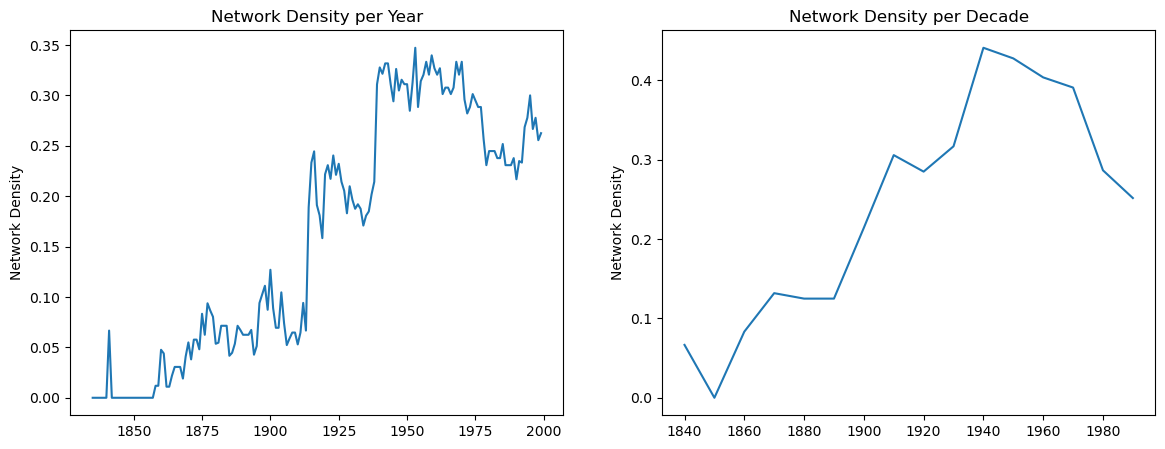

In [157]:
plot_characteristic_year_dec(yearly_densities, decade_densities, "Network Density")

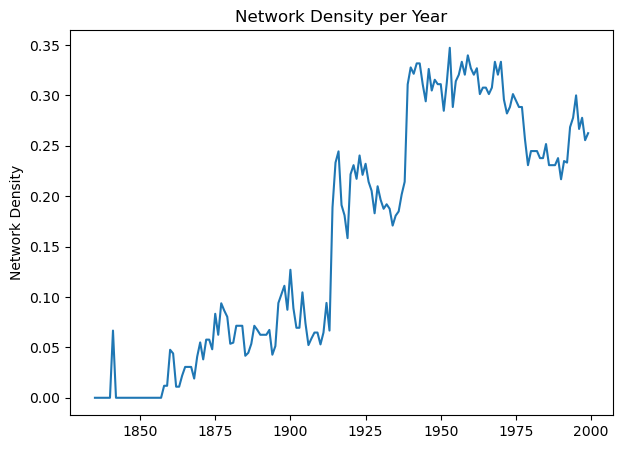

In [158]:
plot_characteristic(yearly_densities, "Network Density")

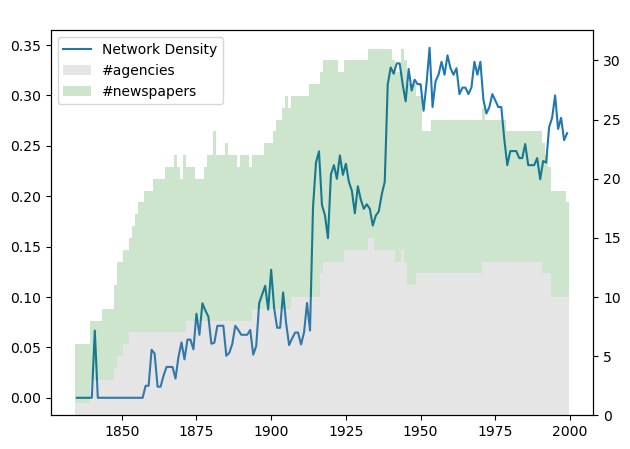

In [160]:
plot_yearly_with_nodefreq(yearly_densities, "Network Density", title=" ")

In [184]:
for year, density in dict(zip(years, yearly_densities)).items():
    if 1910 <= year <= 1920:
        print(f"{year}: density {round(density, 3)}")
    
    elif 1930 <= year <= 1945:
        print(f"{year}: density {round(density, 3)}")

    elif 1985 <= year <= 2000:
        print(f"{year}: density {round(density, 3)}")
#> increase in 1914-15 and 1939

1910: density 0.053
1911: density 0.065
1912: density 0.094
1913: density 0.067
1914: density 0.189
1915: density 0.233
1916: density 0.244
1917: density 0.191
1918: density 0.181
1919: density 0.158
1920: density 0.222
1930: density 0.196
1931: density 0.188
1932: density 0.192
1933: density 0.188
1934: density 0.171
1935: density 0.181
1936: density 0.185
1937: density 0.202
1938: density 0.214
1939: density 0.311
1940: density 0.328
1941: density 0.321
1942: density 0.332
1943: density 0.332
1944: density 0.311
1945: density 0.294
1985: density 0.252
1986: density 0.231
1987: density 0.231
1988: density 0.231
1989: density 0.238
1990: density 0.217
1991: density 0.235
1992: density 0.233
1993: density 0.269
1994: density 0.278
1995: density 0.3
1996: density 0.267
1997: density 0.278
1998: density 0.256
1999: density 0.263


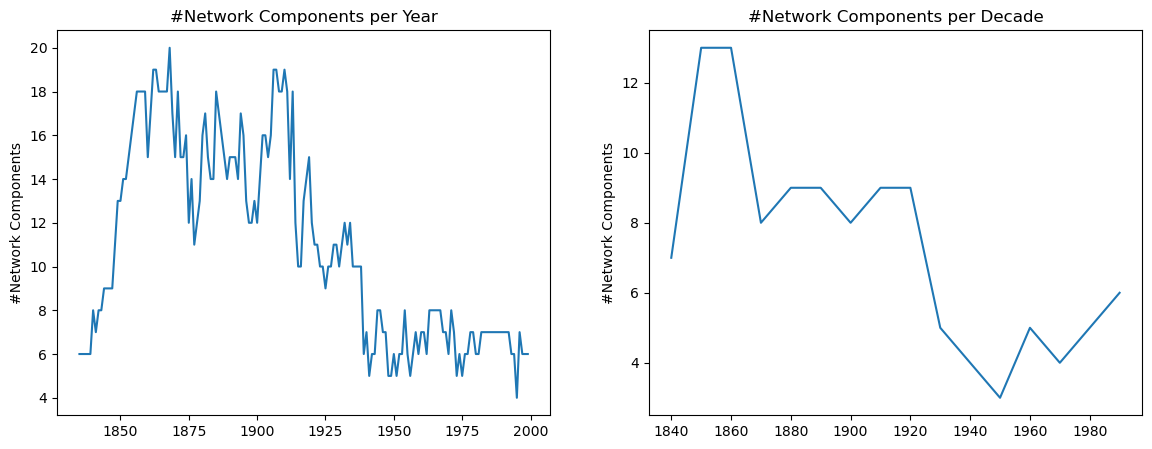

In [93]:
plot_characteristic_year_dec(yearly_components, decade_components, "#Network Components")

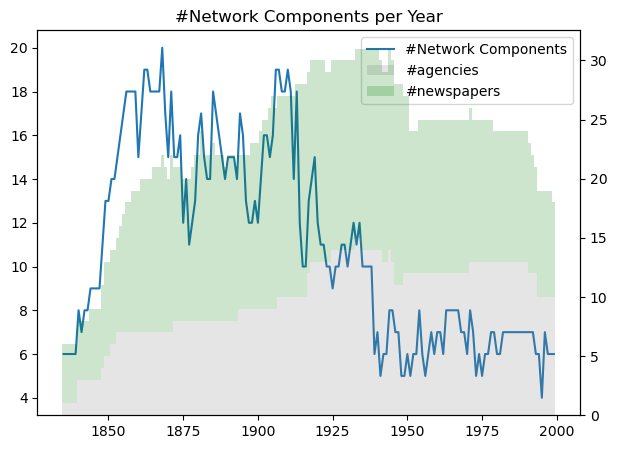

In [94]:
plot_yearly_with_nodefreq(yearly_components, "#Network Components", place_legend='right')

### Analysis without loose nodes

In [150]:
yearly_densities_non0 = [get_density_of_year(G_yearly_min24, year, drop_lonely_nodes=True) for year in years]
yearly_components_non0 = [get_components_of_year(G_yearly_min24, year, drop_lonely_nodes=True) for year in years]

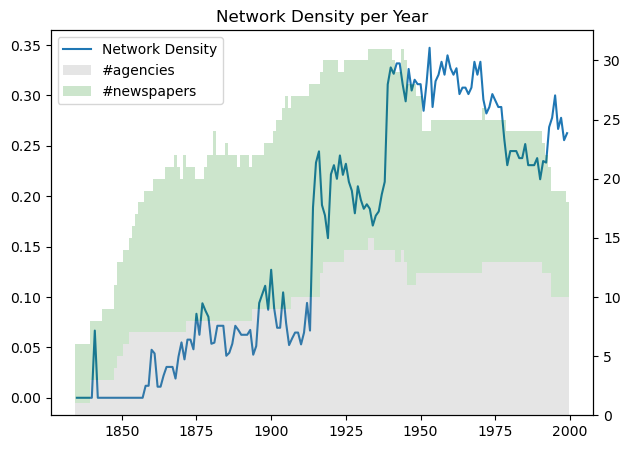

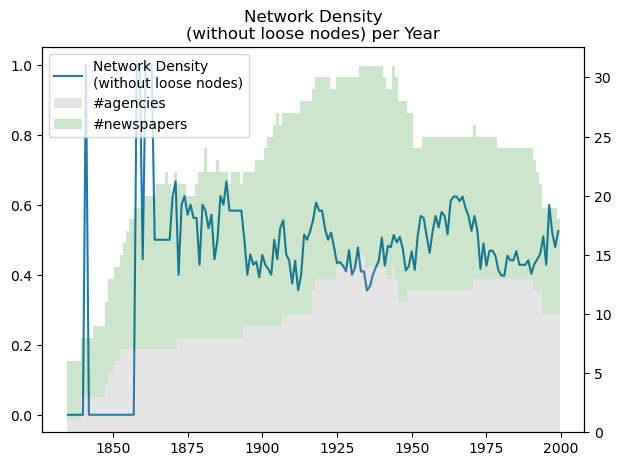

In [152]:
plot_yearly_with_nodefreq(yearly_densities, "Network Density")
plot_yearly_with_nodefreq(yearly_densities_non0, "Network Density\n(without loose nodes)")

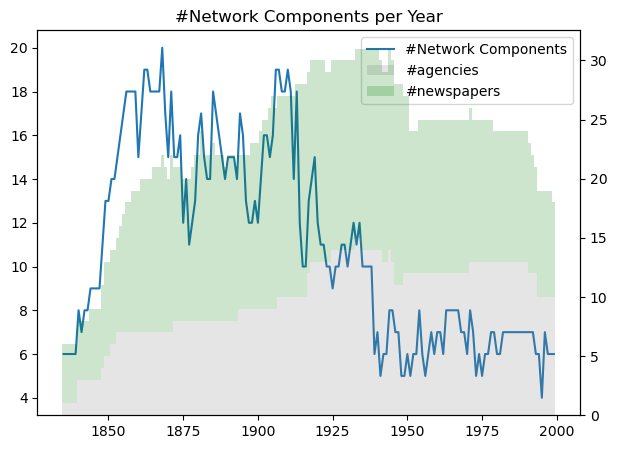

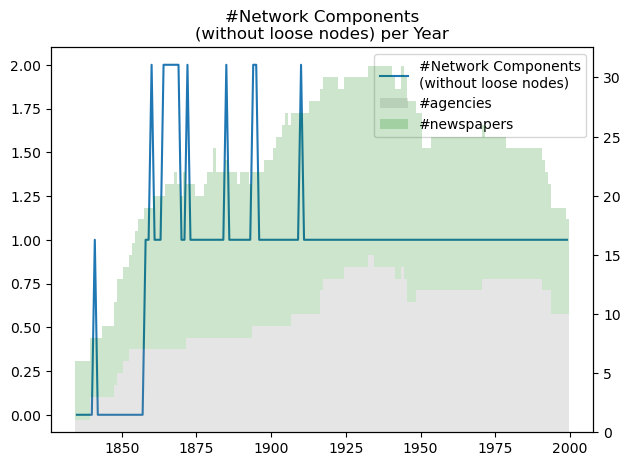

In [155]:
plot_yearly_with_nodefreq(yearly_components, "#Network Components", place_legend='right')
plot_yearly_with_nodefreq(yearly_components_non0, "#Network Components\n(without loose nodes)", place_legend='right')

-> mostly, whole graph is connected if disregarding nodes without any link

### Check indeplux in 1890s -> strong link to Havas in the graph

In [183]:
mentions_all[(mentions_all['newspaper'] == 'indeplux') & (mentions_all['decade'] == 1890)].sample(5, random_state=1)

,entity,surface,qid,lSentenceOffset,rSentenceOffset,sentence_idx:,lArticleOffset,rArticleOffset,id,article,newspaper,date,year,decade,agency,language,country
1998167,org.ent.pressagency.Reuters,Reuter,Q130879,7,13,6,543,549,indeplux-1899-10-04-a-i0031:6:7:13:543:549:new...,indeplux-1899-10-04-a-i0031,indeplux,1899-10-04,1899,1890,Reuters,fr,LU
2228553,org.ent.pressagency.Havas,Hav,Q2826560,210,213,49,4787,4790,indeplux-1899-04-13-a-i0014:49:210:213:4787:47...,indeplux-1899-04-13-a-i0014,indeplux,1899-04-13,1899,1890,Havas,fr,LU
2602757,org.ent.pressagency.Reuters,Reuter,Q130879,161,167,36,4624,4630,indeplux-1899-11-07-a-i0035:36:161:167:4624:46...,indeplux-1899-11-07-a-i0035,indeplux,1899-11-07,1899,1890,Reuters,fr,LU
475563,org.ent.pressagency.Havas,Havas,Q2826560,1,6,6,505,510,indeplux-1898-08-03-a-i0011:6:1:6:505:510:news...,indeplux-1898-08-03-a-i0011,indeplux,1898-08-03,1898,1890,Havas,fr,LU
1973385,org.ent.pressagency.Havas,Havas,Q2826560,29,34,5,607,612,indeplux-1896-03-27-a-i0031:5:29:34:607:612:ne...,indeplux-1896-03-27-a-i0031,indeplux,1896-03-27,1896,1890,Havas,fr,LU


- indeplux-1899-10-04-a-i0031: ...  Vestervik, 3 oct. — M. le comte de Castiilon et M. Maurice Mallet, partis de Paris samedi soir à 6 heures dans le ballon Centaure , ont atterri au vill-ge de Bestrum après un voyage de 23 heures. (Havas Reuter.)
- indeplux-1898-08-03-a-i0011: ...  Des femmes accompagnant les agresseurs ont été mêlées à la bagarre où les carmansiens ont été violemment frappés. (Havas.)
- indeplux-1896-03-27-a-i0031: Voici la dépêche de l’agence Havas : ...

-> actually crediting systematically already

## Saving Graphs

In [98]:
#nx.write_gexf(G_all, output_path + "G_np_ag.gexf")
nx.write_gexf(G_yearly, output_path + "G_yearly.gexf")
nx.write_gexf(G_newspaper, output_path + "G_np.gexf")
nx.write_gexf(G_agencies, output_path + "G_ag.gexf")

In [177]:
nx.write_gexf(G_yearly_min6, output_path + "G_yearly_min6.gexf")
nx.write_gexf(G_yearly_min24, output_path + "G_yearly_min24.gexf")
nx.write_gexf(G_yearly_min24_normalized, output_path + "G_yearly_min24_normalized.gexf")